# Get error distribution

- Created with PtyRAD 0.1.0b12
- Requires PtyRAD >= 0.1.0b8
- Latest demo params files / scripts: https://github.com/chiahao3/ptyrad/tree/main/demo
- Documentation: https://ptyrad.readthedocs.io/en/latest/
- PtyRAD paper: https://doi.org/10.1093/mam/ozaf070
- PtyRAD arXiv: https://arxiv.org/abs/2505.07814
- Zenodo record: https://doi.org/10.5281/zenodo.15273176
- Box folder: https://cornell.box.com/s/n5balzf88jixescp9l15ojx7di4xn1uo
- Youtube channel: https://www.youtube.com/@ptyrad_official

**Before running this notebook, you must first follow the instruction in `README.md` to:**
1. Create the Python environment with all dependant Python packages like PyTorch
2. Activate that python environment
3. Install `ptyrad` package into your activated Python environement (only need to install once)

> Note: This notebook is designed for visualization of the reconstruction error.

Author: Chia-Hao Lee, cl2696@cornell.edu

## 00. Setup working directory and imports

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set this to your desired working directory so you can easily access the data, model, param files
work_dir = "H:/workspace/ptyrad/demo/"

os.chdir(work_dir)
print("Current working dir: ", os.getcwd())
# Note that the output/ directory will be automatically generated under your working directory

Current working dir:  H:\workspace\ptyrad\demo


In [2]:
from ptyrad.initialization import Initializer
from ptyrad.load import load_ptyrad, load_params
from ptyrad.models import PtychoAD
from ptyrad.reconstruction import make_batches, select_scan_indices
from ptyrad.save import save_array
from ptyrad.utils import print_system_info, set_gpu_device, CustomLogger
from ptyrad.visualization import plot_forward_pass

## 01. Setup file path and parse params

In [3]:
model_path   = "output/tBL_WSe2/20250908_full_N16384_dp128_flipT100_random32_p6_1obj_1slice_plr1e-4_oalr5e-4_oplr5e-4_slr2e-3_orblur0.4_ozblur1.0_mamp0.03_4.0_oathr0.96_oposc_sng1.0_spr0.1/model_iter0200.hdf5"
params_path  = "output/tBL_WSe2/20250908_full_N16384_dp128_flipT100_random32_p6_1obj_1slice_plr1e-4_oalr5e-4_oplr5e-4_slr2e-3_orblur0.4_ozblur1.0_mamp0.03_4.0_oathr0.96_oposc_sng1.0_spr0.1/tBL_WSe2_reconstruct.yml"
ckpt         = load_ptyrad(model_path)
params       = load_params(params_path, validate=True)

init_params  = params.get('init_params')
model_params = params.get('model_params')
recon_params = params.get('recon_params')

Success! Loaded .hdf5 file as a dict from path = 'output/tBL_WSe2/20250908_full_N16384_dp128_flipT100_random32_p6_1obj_1slice_plr1e-4_oalr5e-4_oplr5e-4_slr2e-3_orblur0.4_ozblur1.0_mamp0.03_4.0_oathr0.96_oposc_sng1.0_spr0.1/model_iter0200.hdf5'
### Loading params file ###
Success! Loaded .yml file path = output/tBL_WSe2/20250908_full_N16384_dp128_flipT100_random32_p6_1obj_1slice_plr1e-4_oalr5e-4_oplr5e-4_slr2e-3_orblur0.4_ozblur1.0_mamp0.03_4.0_oathr0.96_oposc_sng1.0_spr0.1/tBL_WSe2_reconstruct.yml
validate = True: Filling defaults and validating the params file...
Success! Params file validated and defaults applied.
 


In [4]:
# Modify the init_params so we're loading the reconstructed model
init_params['obj_source'] = 'PtyRAD'
init_params['probe_source'] = 'PtyRAD'
init_params['pos_source'] = 'PtyRAD'
init_params['obj_params'] = model_path
init_params['probe_params'] = model_path
init_params['pos_params'] = model_path

## 02. Initialize logger, device, initializer, and model

In [5]:
logger = CustomLogger(log_file='ptyrad_log.txt', log_dir='auto', prefix_time='datetime', show_timestamp=True)

print_system_info()
device = set_gpu_device(gpuid=0) # Pass in `gpuid = None` if you don't have access to a CUDA-compatible GPU. Note that running PtyRAD with CPU would be much slower than on GPU.
init = Initializer(init_params).init_all()
model = PtychoAD(init.init_variables, model_params, device=device)

2025-09-29 23:10:53,999 - ### PtyRAD Logger configuration ###
2025-09-29 23:10:53,999 - log_file       = 'ptyrad_log.txt'. If log_file = None, no log file will be created.
2025-09-29 23:10:53,999 - log_dir        = 'auto'. If log_dir = 'auto', then log will be saved to `output_path` or 'logs/'.
2025-09-29 23:10:53,999 - flush_file     = True. Automatically set to True if `log_file is not None`
2025-09-29 23:10:53,999 - prefix_time    = datetime. If true, preset strings ('date', 'time', 'datetime'), or a string of time format, a datetime str is prefixed to the `log_file`.
2025-09-29 23:10:53,999 - prefix_jobid   = '0'. If not 0, it'll be prefixed to the log file. This is used for hypertune mode with multiple GPUs.
2025-09-29 23:10:53,999 - append_to_file = True. If true, logs will be appended to the existing file. If false, the log file will be overwritten.
2025-09-29 23:10:53,999 - show_timestamp = True. If true, the printed information will contain a timestamp.
2025-09-29 23:10:54,015

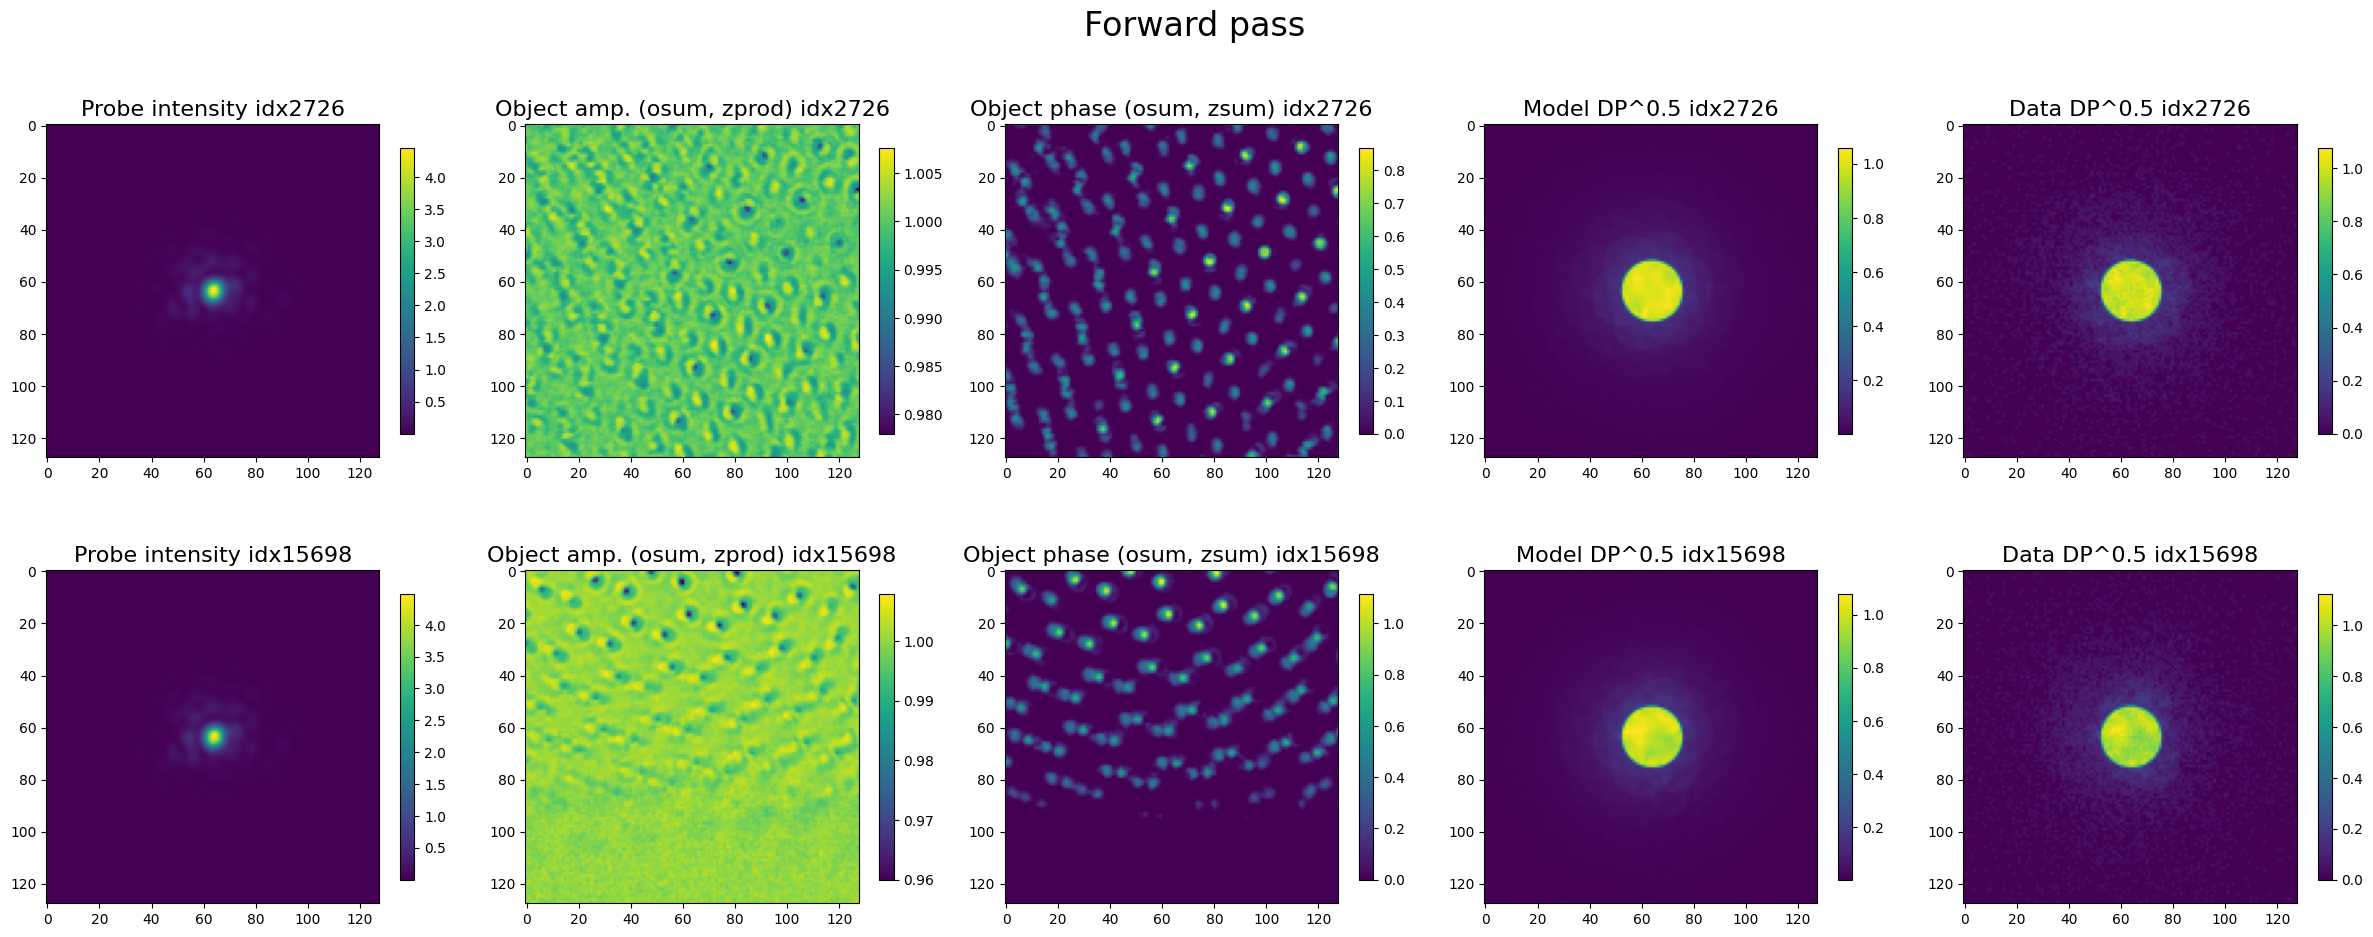

In [6]:
# Run a forward pass to check if the reconstructed model (obj, probe, pos) was correctly loaded
indices = np.random.randint(0, init.init_variables["N_scans"], 2)
dp_power = 0.5
plot_forward_pass(model, indices, dp_power)

## 03. Run 1 full foward pass for the error distribution

In [7]:
INDICES_MODE      = recon_params.get('INDICES_MODE')
batch_config      = recon_params.get('BATCH_SIZE', {})
grad_accumulation = batch_config.get("grad_accumulation", 1)
batch_size        = batch_config.get('size') * grad_accumulation
GROUP_MODE        = recon_params.get('GROUP_MODE')

pos = (model.crop_pos + model.opt_probe_pos_shifts).detach().cpu().numpy()

indices = select_scan_indices(
    init.init_variables['N_scan_slow'],
    init.init_variables['N_scan_fast'],
    subscan_slow=INDICES_MODE.get('subscan_slow'),
    subscan_fast=INDICES_MODE.get('subscan_fast'),
    mode=INDICES_MODE.get('mode', 'random'),
)

batches = make_batches(indices, pos, batch_size, mode=GROUP_MODE)

2025-09-29 23:11:15,134 - Selecting indices with the 'full' mode 
2025-09-29 23:11:16,541 - Generated 512 'random' groups of ~32 scan positions in 0.016 sec


In [8]:
# Initialize error_DP to hold the relative error patterns, note that this would take the same amount of GPU VRAM as the 4D-dataset

Npix = model.get_complex_probe_view().shape[-1]
error_DP = torch.zeros((len(indices), Npix, Npix), device=device, dtype=torch.float32)

In [9]:
dp_pow = 0.5

for batch in batches:
    with torch.no_grad():
        model_DP = model(batch)
        measured_DP = model.get_measurements(batch)
        data_mean   = measured_DP.pow(dp_pow).mean(0).clamp(min=1e-8)
        error_DP[batch] = (model_DP.pow(dp_pow) - measured_DP.pow(dp_pow)) / data_mean # error_DP corresponds to the relative error

In [10]:
error_DP_arr = error_DP.detach().cpu().numpy()

# Saving is optional but you can port it into py4DGUI for interactive visualization
save_array(error_DP_arr, file_dir='./', file_name='relative_error', file_format="hdf5", output_shape=None, append_shape=True,)

2025-09-29 23:11:19,623 - Saving array with shape = (16384, 128, 128) and dtype = float32
2025-09-29 23:11:19,638 - file path = './relative_error_16384_128_128.hdf5' already exists, the file will be overwritten.
2025-09-29 23:12:23,149 - Success! Saved data as 'meas' to .hdf5 file: ./relative_error_16384_128_128.hdf5


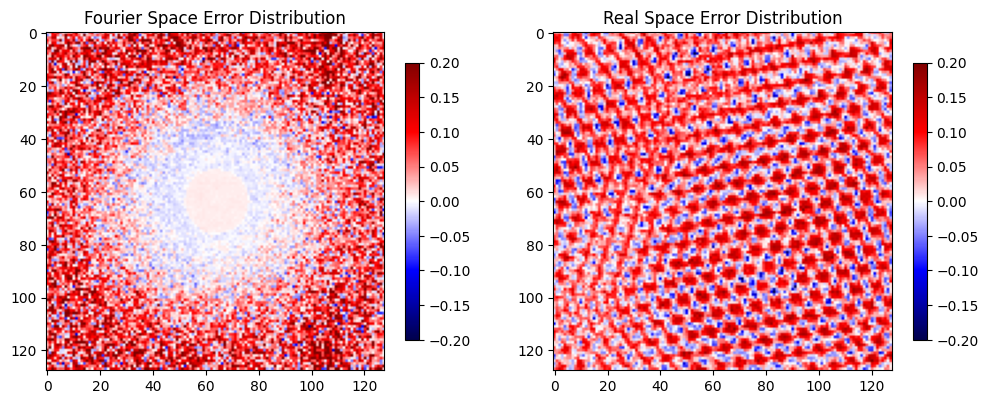

In [11]:
N_scan_slow = init.init_variables['N_scan_slow']
N_scan_fast = init.init_variables['N_scan_fast']

fig, axs = plt.subplots(nrows=1,ncols=2, figsize = (12,6))
axs[0].set_title('Fourier Space Error Distribution')
im0 = axs[0].imshow(error_DP_arr.mean(0), cmap='seismic', vmin=-0.2, vmax=0.2)
fig.colorbar(im0, shrink=0.6)

axs[1].set_title('Real Space Error Distribution')
im1 = axs[1].imshow(error_DP_arr.mean((-1,-2)).reshape(N_scan_slow, N_scan_fast), cmap='seismic', vmin=-0.2, vmax=0.2)
fig.colorbar(im1, shrink=0.6)
plt.show()

## Note
- Since it's relative error, it naturally contains positive and negative values for each error_DP (N, ky, kx)
- If we take the average along N, then inevitably some k pixels would have their errors cancel out.
- Similarly, when we average along (ky, kx), errors for all k pixels would be averaged together and show an overall trend for each probe position.

## Fourier Space Error Distribution
- Low k region (center) shows low relative error, which is more or less expected as it contains most of the signal and generally SNR ~ 1/sqrt(signal)
- High k region has higher relative error, indicating model DP predicts stronger intensity than experiment pattern.

## Real Space Error Distribution
- On atomic sites the relative error tend to be negative values, indicating model DP predicts overall lower intensity than experiment pattern.